In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.contrib.slim as slim

In [2]:
def build_rnn(num_units, num_layers, batch_size, keep_prob=1):
    def build_cell(num_units, keep_prob):
        cell = tf.nn.rnn_cell.BasicRNNCell(num_units)
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
        return cell
    cell = tf.nn.rnn_cell.MultiRNNCell([build_cell(num_units, keep_prob) for _ in range(num_layers)])
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

def rnn(x, num_units, num_layers, batch_size, init_state=None, keep_prob=1,
        time_major=True, scope='rnn', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        cell, zero_state = build_rnn(num_units, num_layers, batch_size, keep_prob)
        if init_state is not None:
            out, final_state = tf.nn.dynamic_rnn(cell, x, initial_state=init_state, time_major=time_major)
        else:
            out, final_state = tf.nn.dynamic_rnn(cell, x, initial_state=zero_state, time_major=time_major)
        return out, final_state

In [3]:
?tf.nn.rnn_cell.BasicRNNCell

In [3]:
def build_lstm(num_units, num_layers, batch_size, keep_prob=1):
    def build_cell(num_units, keep_prob):
        cell = tf.nn.rnn_cell.LSTMCell(num_units)
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
        return cell
    cell = tf.nn.rnn_cell.MultiRNNCell([build_cell(num_units, keep_prob) for _ in range(num_layers)])
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

def lstm(x, num_units, num_layers, batch_size, init_state=None, keep_prob=1, 
         time_major = True, scope='lstm', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        cell, zero_state = build_lstm(num_units, num_layers, batch_size, keep_prob)
        if init_state is not None:
            out, final_state = tf.nn.dynamic_rnn(cell, x, initial_state=init_state, time_major=time_major)
        else:
            out, final_state = tf.nn.dynamic_rnn(cell, x, initial_state=zero_state, time_major=time_major)
        return out, final_state

In [10]:
?tf.nn.dynamic_rnn

In [4]:
def build_gru(num_units, num_layers, batch_size, keep_prob=1):
    def build_cell(num_units, keep_prob):
        cell = tf.nn.rnn_cell.GRUCell(num_units)
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
        return cell
    cell = tf.nn.rnn_cell.MultiRNNCell([build_cell(num_units,keep_prob) for _ in range(num_layers)])
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

def gru(x, num_units, num_layers, batch_size, init_state=None, keep_prob=1, 
        time_major=True, scope='gru', reuse=None):
    with tf.variable_scope(scope):
        cell, zero_state = build_gru(num_units, num_layers, batch_size, keep_prob)
        if init_state is not None:
            out, final_state = tf.nn.dynamic_rnn(cell, x, initial_state=init_state, time_major=time_major)
        else:
            out. final_state = tf.nn.dynamic_rnn(cell, x, initial_state=zero_state, time_major= time_major)
        
        return out,final_state

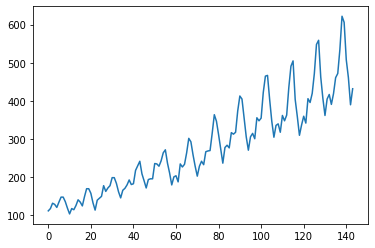

In [2]:
data_csv = pd.read_csv("./airplane_traffic.csv",usecols=[1])

plt.plot(data_csv)

data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')

max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x/scalar , dataset))

def creat_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

dataX, dataY = creat_dataset(dataset)

train_size = int(len(dataX)*0.7)
test_size = len(dataX) - train_size
train_X = dataX[:train_size]
train_Y = dataY[:train_size]
test_X = dataX[train_size:]
test_Y = dataY[train_size:]

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1,1,2)
test_Y = test_Y.reshape(-1,1,1)

In [5]:
train_X.shape

(99, 1, 2)

In [4]:
train_X[0]

array([[0.21621622, 0.22779922]], dtype=float32)

In [6]:
inpu_ph = tf.placeholder(shape=[None,1,2], dtype=tf.float32, name='input')
target_ph = tf.placeholder(shape=[None,1,1], dtype=tf.float32, name='target')

def lstm_reg(inputs, num_units, output_size =1 , keep_prob=1, num_layers=2, scope='lstm_reg', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        net, state = lstm(inputs, num_units, num_layers, 1, keep_prob=keep_prob)
        s,b,n = net.get_shape().as_list()
        net = tf.reshape(net , (-1, num_units))
        net = slim.fully_connected(net, output_size, activation_fn=None, scope='regression')
        net = tf.reshape(net,(-1,b,output_size))
        return net

out = lstm_reg(inpu_ph, 4)

loss = tf.losses.mean_squared_error(target_ph, out)

opt = tf.train.AdamOptimizer(1e-2)
train_op = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Epoch: 100, loss: 0.00055
Epoch: 200, loss: 0.00051
Epoch: 300, loss: 0.00052
Epoch: 400, loss: 0.00045
Epoch: 500, loss: 0.00044
Epoch: 600, loss: 0.00043
Epoch: 700, loss: 0.00040
Epoch: 800, loss: 0.00039
Epoch: 900, loss: 0.00042
Epoch: 1000, loss: 0.00037
Epoch: 1100, loss: 0.00037
Epoch: 1200, loss: 0.00036
Epoch: 1300, loss: 0.00039
Epoch: 1400, loss: 0.00034
Epoch: 1500, loss: 0.00036
Epoch: 1600, loss: 0.00033
Epoch: 1700, loss: 0.00031
Epoch: 1800, loss: 0.00034
Epoch: 1900, loss: 0.00035
Epoch: 2000, loss: 0.00027
Epoch: 2100, loss: 0.00031
Epoch: 2200, loss: 0.00025
Epoch: 2300, loss: 0.00024
Epoch: 2400, loss: 0.00023
Epoch: 2500, loss: 0.00023
Epoch: 2600, loss: 0.00032
Epoch: 2700, loss: 0.00042
Epoch: 2800, loss: 0.00029
Epoch: 2900, loss: 0.00026
Epoch: 3000, loss: 0.00024


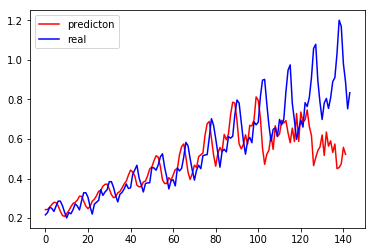

In [24]:
for e in range(3000):
    feed_dict = {inpu_ph: train_X, target_ph:train_Y}
    sess.run(train_op, feed_dict=feed_dict)
    if (e+1)%100 ==0 :
        print("Epoch: {}, loss: {:.5f}".format(e+1, sess.run(loss, feed_dict=feed_dict)))

data_X = dataX.reshape((-1,1,2))
pred_test = sess.run(out, feed_dict={inpu_ph:data_X})
pred_test = pred_test.flatten()

plt.plot(pred_test, 'r', label='predicton')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

